In [1]:
import os
import warnings

import numpy as np
import pymc3 as pm
import bambi
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import pandas as pd
import pandas_profiling
from scipy import stats

from sklearn.linear_model import LinearRegression

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
#%config InlineBackend.figure_format = 'retina'
#az.style.use("arviz-darkgrid")
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.2
Running on ArviZ v0.11.2


In [3]:
data_dir = '/home/telescreen/Workspace/fun/pymc-devs-resources/Rethinking_2/Data/'
data = pd.read_csv(os.path.join(data_dir, 'WaffleDivorce.csv'), sep=';')
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [4]:
data.shape

(50, 13)

In [5]:
np.std(data.MedianAgeMarriage)

1.2311311871608157

In [6]:
data['WaffleHousesPerMil'] = data.WaffleHouses / data.Population

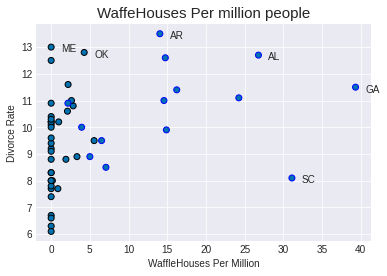

In [7]:
colors = {"1": "blue", "0": "black"}
plt.scatter(
    data.WaffleHousesPerMil,
    data.Divorce,
    lw=1,
    edgecolors=data.South.apply(lambda c: colors[str(c)])
)
plt.xlabel("WaffleHouses Per Million")
plt.ylabel("Divorce Rate")
plt.title("WaffeHouses Per million people", fontsize=15)
selection = data[
    (data["Divorce"] > 12.6) | (data["WaffleHouses"] / data["Population"] > 30)
]
for loc, div, wpm in zip(
    selection['Loc'], 
    selection['Divorce'], 
    selection['WaffleHousesPerMil']):
    plt.annotate(f"{loc}", xy=(wpm, div), textcoords="offset points", xytext=(10, -5))

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Location            50 non-null     object 
 1   Loc                 50 non-null     object 
 2   Population          50 non-null     float64
 3   MedianAgeMarriage   50 non-null     float64
 4   Marriage            50 non-null     float64
 5   Marriage SE         50 non-null     float64
 6   Divorce             50 non-null     float64
 7   Divorce SE          50 non-null     float64
 8   WaffleHouses        50 non-null     int64  
 9   South               50 non-null     int64  
 10  Slaves1860          50 non-null     int64  
 11  Population1860      50 non-null     int64  
 12  PropSlaves1860      50 non-null     float64
 13  WaffleHousesPerMil  50 non-null     float64
dtypes: float64(8), int64(4), object(2)
memory usage: 5.6+ KB


In [9]:
data.describe()

,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,WaffleHousesPerMil
count,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000
mean,6.119600,26.05400,20.114000,1.399400,9.688000,0.961800,32.340000,0.280000,79378.340000,6.287293e+05,0.094051,4.947834
std,6.876156,1.24363,3.797905,0.796975,1.820814,0.525367,65.789587,0.453557,149730.921149,7.813127e+05,0.174449,8.958811
min,0.560000,23.20000,13.500000,0.390000,6.100000,0.240000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,1.635000,25.32500,17.125000,0.810000,8.300000,0.572500,0.000000,0.000000,0.000000,4.332100e+04,0.000000,0.000000
50%,4.435000,25.90000,19.700000,1.185000,9.750000,0.795000,1.000000,0.000000,0.000000,4.077220e+05,0.000000,0.077942
75%,6.677500,26.75000,22.100000,1.767500,10.900000,1.257500,39.750000,1.000000,80828.000000,9.209770e+05,0.085000,4.816667
max,37.250000,29.70000,30.700000,3.920000,13.500000,2.500000,381.000000,1.000000,490865.000000,3.880735e+06,0.570000,39.318885


In [10]:
def plot_with_regression(ydata, xdata):
    lr = LinearRegression()
    regression_result = lr.fit(data[xdata].values.reshape(-1, 1), data[ydata].values)
    plt.scatter(data[xdata], data[ydata])
    plt.plot(data[xdata].values, regression_result.predict(data[xdata].values.reshape(-1, 1)), color='r')    
    plt.xlabel(xdata)
    plt.ylabel(ydata)
    plt.title(f'{ydata} ~ {xdata}')

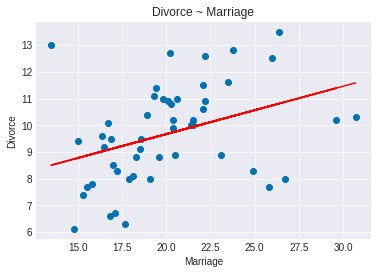

In [11]:
plot_with_regression('Divorce', 'Marriage')

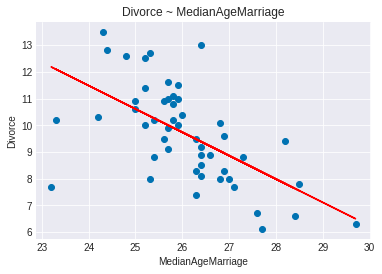

In [12]:
plot_with_regression('Divorce', 'MedianAgeMarriage')

In [13]:
def standardize(data):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1,1))
    return scaled_data

In [14]:
data['Marriage_std'] = standardize(data.Marriage)
data['Divorce_std'] = standardize(data.Divorce)
data['MedianAgeMarriage_std'] = standardize(data.MedianAgeMarriage)

In [15]:
np.min(data.MedianAgeMarriage_std), np.max(data.MedianAgeMarriage_std)

(-2.3181932435500827, 2.9615040525520757)

In [16]:
with pm.Model() as m5_1:    
    Age = pm.Normal("Age", 0, 0.5)
    intercept = pm.Normal("intercept", 0, 0.2)
    sigma = pm.Exponential("sigma", 1)
    mu = intercept + Age * data.MedianAgeMarriage_std
    Divorce = pm.Normal("Divorce", mu, sigma, observed=data.Divorce_std)
    # Run samples
    priors = pm.sample_prior_predictive()
    trace5_1 = pm.sample()
    posteriors = pm.sample_posterior_predictive(trace5_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, Age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>]], dtype=object)

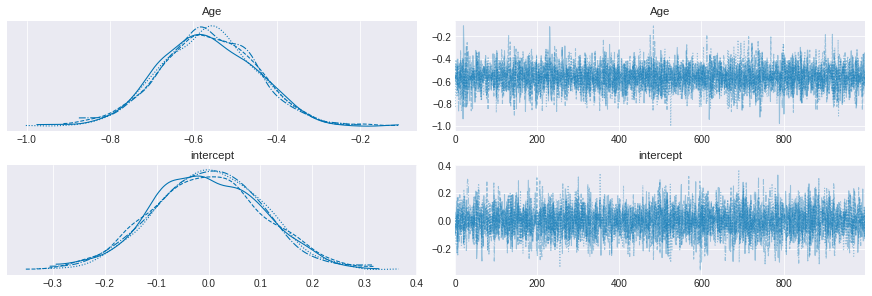

In [17]:
az.plot_trace(trace5_1, var_names=['Age', 'intercept'])

In [18]:
az.summary(trace5_1, kind='stats')

,mean,sd,hdi_3%,hdi_97%
Age,-0.566,0.115,-0.777,-0.350
intercept,-0.001,0.106,-0.208,0.189
sigma,0.831,0.086,0.686,0.998


<AxesSubplot:>

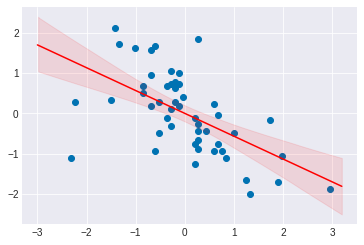

In [19]:
age_std_seq = np.linspace(-3, 3.2, 30)
mu_pred = np.zeros((len(age_std_seq), len(trace5_1)*trace5_1.nchains))
for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = trace5_1['Age'] * age_std + trace5_1['intercept']
mu_mean = mu_pred.mean(axis=1)
plt.scatter(data.MedianAgeMarriage_std, data.Divorce_std)
plt.plot(age_std_seq, mu_mean, color='r')
az.plot_hdi(age_std_seq, mu_pred.T, ax=plt.gca(), color='r', fill_kwargs={'alpha': 0.1})

In [20]:
with pm.Model() as m5_2:
    intercept = pm.Normal('intercept', mu=0, sigma=0.2)
    Marriage = pm.Normal('Marriage', mu=0, sigma=0.5)
    Age = pm.Normal('Age', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = intercept + Marriage*data.Marriage_std + Age*data.MedianAgeMarriage_std
    Divorce = pm.Normal('Divorce', mu, sigma, observed=data.Divorce_std)
    trace5_2 = pm.sample()
    posterior = pm.sample_posterior_predictive(trace5_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Age, Marriage, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [21]:
az.summary(trace5_2, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
intercept,0.00,0.10,-0.18,0.18
Marriage,-0.06,0.16,-0.36,0.24
Age,-0.61,0.16,-0.91,-0.31
sigma,0.84,0.09,0.68,1.01


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

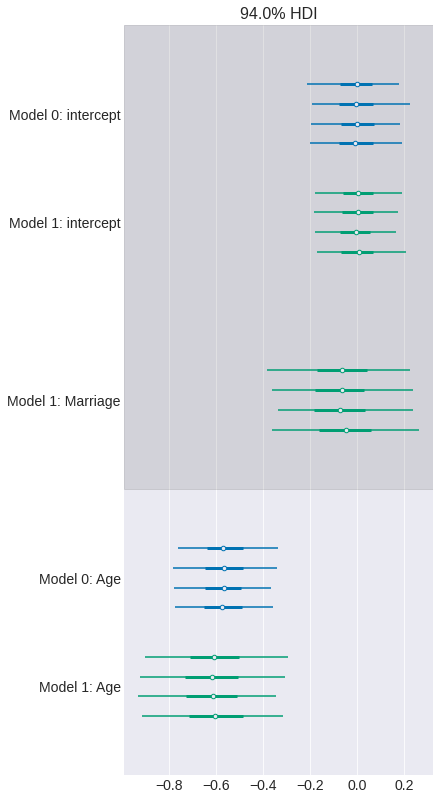

In [22]:
az.plot_forest([trace5_1, trace5_2], var_names=['intercept', 'Marriage', 'Age'])

In [23]:
milk = pd.read_csv(os.path.join(data_dir, 'milk.csv'), sep=';')
milk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


In [24]:
milk.describe()

,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
count,29.000000,29.000000,29.000000,29.000000,29.000000,17.000000
mean,0.641724,33.990345,16.403448,49.606207,14.726897,67.575882
std,0.161402,14.286670,4.846878,14.055174,24.770469,5.968612
min,0.460000,3.930000,7.370000,27.090000,0.120000,55.160000
25%,0.490000,21.220000,13.000000,37.800000,1.620000,64.540000
50%,0.600000,36.840000,15.800000,48.640000,3.470000,68.850000
75%,0.730000,46.080000,20.770000,60.120000,10.720000,71.260000
max,0.970000,55.510000,25.300000,71.910000,97.720000,76.300000


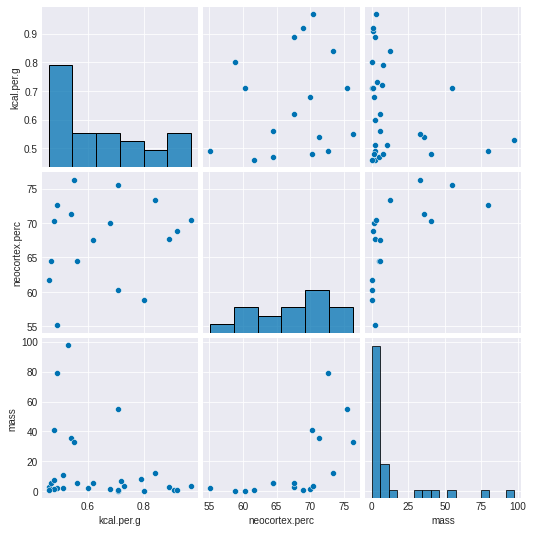

In [25]:
sns.pairplot(data=milk, vars=['kcal.per.g', 'neocortex.perc', 'mass'])

In [26]:
milk['K'] = standardize(milk['kcal.per.g'])
milk['M'] = standardize(milk['mass'])
milk['N'] = standardize(milk['neocortex.perc'])

In [27]:
milk.dropna(inplace=True)
milk.shape

(17, 11)

In [28]:
with pm.Model() as m5_5:
    intercept = pm.Normal('intercept', 0, 0.2)
    Neocortex_perc = pm.Normal('Neocortex_perc', 0, 0.5)
    mu = Neocortex_perc * milk.N + intercept
    sigma = pm.Exponential('sigma', 1)
    Kcal_per_g = pm.Normal('Kcal_per_g', mu, sigma, observed=milk.K)
    prior5_5 = pm.sample_prior_predictive()
    trace5_5 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Neocortex_perc, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


(-2.0, 2.0)

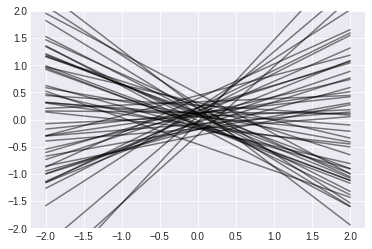

In [29]:
xseq = np.linspace(-2,2,50)
for i in range(50):
    Kcalm5_5 = prior5_5['Neocortex_perc'][i] * xseq + prior5_5['intercept'][i]
    plt.plot(xseq, Kcalm5_5, color='k', alpha=0.5)
plt.ylim(-2, 2)

In [30]:
az.summary(trace5_5, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.036,0.160,-0.213,0.295,0.002,0.003,4778.0,2726.0,1.0
Neocortex_perc,0.123,0.232,-0.234,0.494,0.003,0.003,4715.0,3101.0,1.0
sigma,1.132,0.212,0.813,1.442,0.003,0.003,3830.0,2372.0,1.0


<AxesSubplot:>

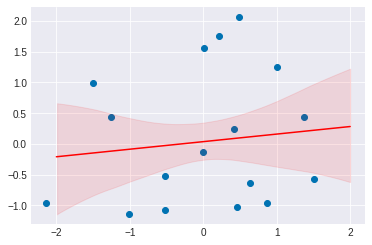

In [31]:
neocortex_seq = np.linspace(-2, 2, 30)
mu_pred = np.zeros((len(neocortex_seq), len(trace5_5)*trace5_5.nchains))
for i, neocortex in enumerate(neocortex_seq):
    mu_pred[i] = trace5_5['Neocortex_perc'] * neocortex + trace5_5['intercept']
mu_mean = mu_pred.mean(axis=1)
plt.scatter(milk.N, milk.K)
plt.plot(neocortex_seq, mu_mean, color='r')
az.plot_hdi(neocortex_seq, mu_pred.T, ax=plt.gca(), color='r', fill_kwargs={'alpha': 0.1})

In [32]:
milk['logmass'] = np.log(milk.mass)
milk.logmass.min(), milk.logmass.max()

(-2.120263536200091, 4.374876130645041)

In [33]:
with pm.Model() as m5_6:
    intercept = pm.Normal('intercept', 0, 0.2)
    Mass = pm.Normal('Mass', 0, 0.5)
    mu = Mass * milk.M + intercept
    sigma = pm.Exponential('sigma', 1)
    Kcal_per_g = pm.Normal('Kcal_per_g', mu, sigma, observed=milk.K)
    trace5_6 = pm.sample()
az.summary(trace5_6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Mass, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.047,0.159,-0.254,0.339,0.002,0.002,4486.0,2616.0,1.00
Mass,-0.307,0.251,-0.795,0.149,0.004,0.003,4475.0,2688.0,1.01
sigma,1.075,0.204,0.753,1.482,0.003,0.002,4066.0,2489.0,1.00


<AxesSubplot:>

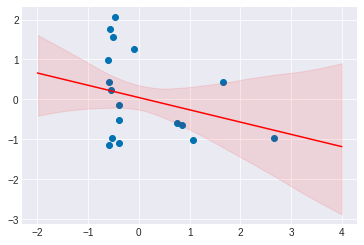

In [34]:
mass_seq = np.linspace(-2, 4, 30)
mu_pred = np.zeros((len(mass_seq), len(trace5_6)*trace5_6.nchains))
for i, mass in enumerate(mass_seq):
    mu_pred[i] = trace5_6['Mass'] * mass + trace5_6['intercept']
mu_mean = mu_pred.mean(axis=1)
plt.scatter(milk.M, milk.K)
plt.plot(mass_seq, mu_mean, color='r')
az.plot_hdi(mass_seq, mu_pred.T, ax=plt.gca(), color='r', fill_kwargs={'alpha': 0.1})

In [35]:
with pm.Model() as m5_7:
    intercept = pm.Normal('intercept', 0, 0.2)
    Neocortex_perc = pm.Normal('Neocortex_perc', 0, 0.5)
    Mass = pm.Normal('Mass', 0, 0.5)
    mu = Neocortex_perc * milk.N + Mass*milk.M + intercept
    sigma = pm.Exponential('sigma', 1)
    Kcal_per_g = pm.Normal('Kcal_per_g', mu, sigma, observed=milk.K)
    trace5_7 = pm.sample()
az.summary(trace5_7)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Mass, Neocortex_perc, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.062,0.155,-0.220,0.367,0.003,0.002,3554.0,2695.0,1.0
Neocortex_perc,0.374,0.259,-0.126,0.855,0.006,0.004,2184.0,2544.0,1.0
Mass,-0.507,0.273,-1.003,0.008,0.006,0.004,2101.0,2339.0,1.0
sigma,0.990,0.197,0.662,1.355,0.004,0.003,2504.0,2268.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

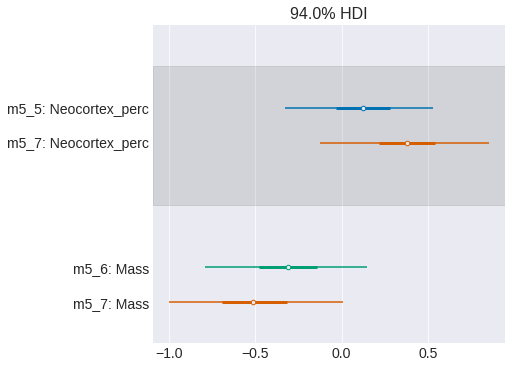

In [36]:
az.plot_forest([trace5_5, trace5_6, trace5_7], model_names=['m5_5', 'm5_6', 'm5_7'], var_names=['Neocortex_perc', 'Mass'], combined=True, figsize=(7,5))

In [37]:
# Generate Causal Data
# M -> K <- N
# M -> N
DATA_SIZE = 100
M = stats.norm().rvs(DATA_SIZE)
N = stats.norm(M).rvs(DATA_SIZE)
K = stats.norm(N-M).rvs(DATA_SIZE)
dsim = pd.DataFrame(data={'M': M, 'N': N, 'K': K})
dsim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M       100 non-null    float64
 1   N       100 non-null    float64
 2   K       100 non-null    float64
dtypes: float64(3)
memory usage: 2.5 KB


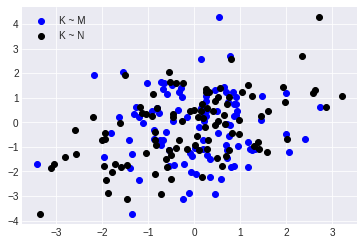

In [38]:
plt.scatter(M, K, color='blue', label='K ~ M')
plt.scatter(N, K, color='k', label='K ~ N')
plt.legend()

In [39]:
priors = {
    'Intercept': bambi.Prior('Normal', mu=0, sd=0.2),
    'N': bambi.Prior('Normal', mu=0, sd=0.5),
    'sigma': bambi.Prior('Exponential', lam=1)
}
m5_5 = bambi.Model('K ~ N', data=dsim, priors=priors)
m5_5result = m5_5.fit()
az.summary(m5_5result)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [K_sigma, N, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.114,0.107,-0.311,0.090,0.001,0.001,5378.0,2896.0,1.0
N,0.506,0.087,0.348,0.673,0.001,0.001,5527.0,3003.0,1.0
K_sigma,1.206,0.088,1.053,1.379,0.001,0.001,5456.0,2669.0,1.0


In [40]:
priors = {
    'Intercept': bambi.Prior('Normal', mu=0, sd=0.2),
    'M': bambi.Prior('Normal', mu=0, sd=0.5),
    'sigma': bambi.Prior('Exponential', lam=1)
}
m5_6 = bambi.Model('K ~ M', data=dsim)
m5_6result = m5_6.fit()
az.summary(m5_6result)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [K_sigma, M, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.211,0.139,-0.476,0.037,0.002,0.002,4952.0,2842.0,1.0
M,0.065,0.135,-0.197,0.314,0.002,0.002,5369.0,2423.0,1.0
K_sigma,1.406,0.102,1.226,1.601,0.001,0.001,5485.0,2811.0,1.0


In [41]:
priors = {
    'Intercept': bambi.Prior('Normal', mu=0, sd=0.2),
    'M': bambi.Prior('Normal', mu=0, sd=0.5),
    'N': bambi.Prior('Normal', mu=0, sd=0.5),
    'sigma': bambi.Prior('Exponential', lam=1)
}
m5_7 = bambi.Model('K ~ M + N', data=dsim)
m5_7result = m5_7.fit()
az.summary(m5_7result)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [K_sigma, N, M, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.050,0.095,-0.234,0.124,0.002,0.001,3363.0,2705.0,1.0
M,-1.031,0.145,-1.290,-0.758,0.003,0.002,2228.0,2519.0,1.0
N,1.091,0.108,0.889,1.289,0.002,0.002,2284.0,2618.0,1.0
K_sigma,0.965,0.071,0.840,1.100,0.001,0.001,3331.0,2737.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

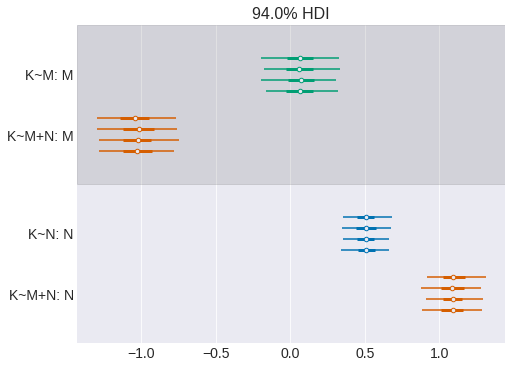

In [42]:
az.plot_forest([m5_5result, m5_6result, m5_7result], model_names=['K~N', 'K~M', 'K~M+N'], var_names=['M', 'N'], figsize=(7,5))

In [49]:
## FACTORS
howell = pd.read_csv(os.path.join(data_dir, 'Howell1.csv'), sep=';')
howell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


In [56]:
with pm.Model() as m5_8:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Normal('mu', 178, 20, shape=2)
    height = pm.Normal('height', mu[howell.male], sigma, observed=howell.height)
    diffmf = pm.Deterministic('DiffHeight', mu[1] - mu[0])
    trace5_8 = pm.sample()
    post5_8 = pm.sample_posterior_predictive(trace5_8)
az.summary(trace5_8)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.904,1.607,131.979,137.976,0.021,0.015,5709.0,2883.0,1.0
mu[1],142.566,1.690,139.451,145.723,0.024,0.017,4842.0,3331.0,1.0
sigma,27.429,0.855,25.836,29.019,0.012,0.009,4940.0,2985.0,1.0
DiffHeight,7.662,2.347,3.462,12.200,0.034,0.024,4864.0,3015.0,1.0


In [55]:
post5_8['height'].shape

(4000, 544)

In [59]:
milk['clade'].unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

In [62]:
milk['clade_id'] = pd.Categorical(milk.clade).codes

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

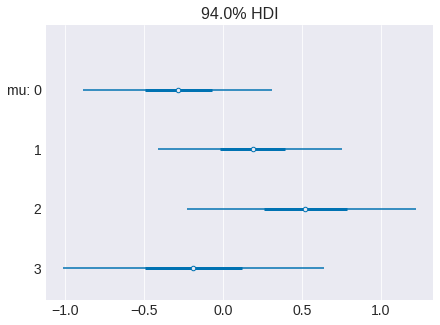

In [64]:
with pm.Model() as m5_9:
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Normal('mu', 0, 0.5, shape=milk['clade_id'].max()+1)
    K = pm.Normal('K', mu[milk.clade_id], sigma, observed=milk.K)
    trace5_9 = pm.sample()
    
az.plot_forest(trace5_9, combined=True, var_names=['mu'])